In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
from torch.utils.data import Dataset, DataLoader# For custom data-sets
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple
import torch.nn as nn
import torch
from torchvision import utils
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import torch.nn as nn
import pandas as pd 
import matplotlib.pyplot as plt
from collections import defaultdict

In [28]:
# Dataloader code
n_class    = 27

# a label and all meta-data
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None, resize=True):
        self.data      = pd.read_csv(csv_file)
        self.n_class   = n_class
        self.mode = csv_file
        self.resize = resize
        
        # Resize the image to 256x256
        self.resize_transform = transforms.Resize((256, 256))
        
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        img_name = self.data.iloc[idx, 0]
        img_name = "drive/MyDrive/image_segmentation_project/" + img_name
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label_name = "drive/MyDrive/image_segmentation_project/" + label_name
        label = Image.open(label_name)
        
        if self.resize:
            img = self.resize_transform(img)
            label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        
        img = self.transforms(img).float() # Normalization
        label = torch.from_numpy(label.copy()).long() # convert to tensor

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        
        return img, target, label

In [29]:
# ResNet block
class resNetBlock(nn.Module):
    """
        Defines a basic ResNet block that we are going to use for semantic segmentation
    """
    def __init__(self, n):
        """
            Args: n - Number of feature maps in each block
        """
        super(resNetBlock, self).__init__()
        self.nf = n
        self.model = self.build_block(n)
        
    def build_block(self, n):
        """
            Args: n - Number of feature maps in each block
        """
        model = []
        model += 2 * [
            nn.ReflectionPad2d(1),
            nn.Conv2d(n, n, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.01, inplace=True)
            
        ]
        return nn.Sequential(*model)
    
    def forward(self, x):
        """
            Args : x - Input that needs to be forward passed
        """
        return x + self.model(x)

# ResNet model for Semantic segmentation
class resNet(nn.Module):
    """
        Class that denotes a Residual network based semantic segmentation model
    """
    def __init__(self, n_class, n=128, debug_mode=False):
        super().__init__()
        self.n_class = n_class
        self.n = n
        self.debug_mode = debug_mode
        self.block = self.model(n)
        
    def model(self, n):
        """
            Callable to execute the model
        """
        self.refPad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.leakyRelu = nn.LeakyReLU(0.01, inplace=True)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, dilation=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bnd1 = nn.BatchNorm2d(128)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bnd2 = nn.BatchNorm2d(64)
        
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bnd3 = nn.BatchNorm2d(32)

        self.classifier = nn.Conv2d(32, 27, kernel_size=1)

    def forward(self, x):
        """
            Forward function
        """
        x1 = self.bn1(self.leakyRelu(self.conv1(x)))
        if(self.debug_mode):
            print("Dimensions after first pass of pad, conv, BN, Relu = {}".format(x1.shape))
        x2 = self.bn2(self.leakyRelu(self.conv2(x1)))
        if(self.debug_mode):
            print("Dimensions after second pass of pad, conv, BN, Relu = {}".format(x2.shape))
        x3 = self.bn3(self.leakyRelu(self.conv3(x2)))
        if(self.debug_mode):
            print("Dimensions after third pass of pad, conv, BN, Relu = {}".format(x3.shape))
        
        # Short skip connections
        x4 = self.bn4(self.leakyRelu(self.conv4(x3)))
        if(self.debug_mode):
            print("Dimensions after fourth pass of pad, conv, BN, Relu = {}".format(x4.shape))
        x5 = x4 + x3
        if(self.debug_mode):
            print("Dimensions after short skip connection 1 = {}".format(x5.shape))
        
        # Short skip connections
        x6 = self.bn4(self.leakyRelu(self.conv4(x5)))
        if(self.debug_mode):
            print("Dimensions after sixth pad, conv, BN, Relu = {}".format(x6.shape))
        x7 = x6 + x5
        if(self.debug_mode):
            print("Dimensions after short skip connection 2 = {}".format(x7.shape))
        
        # Short skip connections
        x8 = self.bn4(self.leakyRelu(self.conv4(x7)))
        if(self.debug_mode):
            print("Dimensions after eighth pass of pad, conv, BN, Relu = {}".format(x8.shape))
        x9 = x8 + x7
        if(self.debug_mode):
            print("Dimensions after short skip connection 3 = {}".format(x9.shape))
        
        tr1 = self.bnd1(self.leakyRelu(self.deconv1(x9)))
        if(self.debug_mode):
            print("Dimensions of tr1 is {}".format(tr1.shape))
        tr2 = self.bnd2(self.leakyRelu(self.deconv2(tr1)))
        if(self.debug_mode):
            print("Dimensions of tr2 is {}".format(tr2.shape))
        tr3 = self.bnd3(self.leakyRelu(self.deconv3(tr2)))
        if(self.debug_mode):
            print("Dimensions of tr3 is {}".format(tr3.shape))
        
        output_decoder = self.classifier(tr3)
        if(self.debug_mode):
            print("Dimensions of the output_decoder is {}".format(output_decoder.shape))
        
        return output_decoder
        

In [30]:
# Code to compute both IoU and pixel accuracy for the model
def iou(pred, target, compute_pix_acc=True):
    """
        Compute both IoU and pixel accuracy for the given parameters
    """
    torch.backends.cudnn.enabled = True
    ious = []
    total = torch.zeros(pred.shape[0]).long().cuda()
    union = torch.zeros(pred.shape[0]).long().cuda()
    int_sum = torch.zeros(pred.shape[0]).long().cuda()
    uni_sum = torch.zeros(pred.shape[0]).long().cuda()
    n_class = 27
    ious = []
    
    # Here, we don't include all the classes for the computation of the image.
    for cls in range(n_class-1):
        # Create a temporary variable
        tensor = torch.Tensor(np.full(pred.shape, cls)).long().cuda()
        # Compare these values
        a = (pred == tensor)
        b = (target == tensor)
        # Intersection - Both layers are providing same class label
        intersection = torch.sum(a & b, dim=(1, 2))
        # Union - Either of layers providing the same class label
        union = torch.sum(a | b, dim=(1, 2))
        # Computing sum values
        uni_sum = uni_sum + union
        int_sum = int_sum + intersection
        # Computing the total number of values in the pixel
        total = total + torch.sum(b, dim=(1, 2))
        
        iou = torch.Tensor.float(torch.Tensor.float(intersection)/torch.Tensor.float(union))
        # To avoid the presence of "nan"
        iou = iou[union != 0]
        iou = torch.mean(iou)
        # Inserting iou to the list of ious.
        ious.append(iou)
        
    int_sum = torch.Tensor.float(int_sum)
    uni_sum = torch.Tensor.float(uni_sum)
    total = torch.Tensor.float(total)
    avg_iou = torch.mean(torch.Tensor.float(int_sum/uni_sum))
    pix_acc = torch.mean(torch.Tensor.float(int_sum/total))
            
    return ious, float(avg_iou), float(pix_acc)

In [31]:
# Code for training, validating and testing the model

# Code for initializing weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

# dice_coefficient_loss() used to compute the Dice Coefficient loss function
# will be used later for training the neural network
class dice_coefficient_loss(nn.Module):
    def __init__(self):
        """
            Initialize the constructor for this class
        """
        super(dice_coefficient_loss, self).__init__()
    
    def forward(self, pred, target):
        axes = tuple(range(2, len(pred.shape)))
        numerator = 2 * torch.sum(pred * target, axes)
        denominator = torch.sum((pred * pred) + (target * target), axes)
        return 1 - torch.mean((numerator + 1e-6) / (denominator + 1e-6))

# Code for training the model
def train(learning_rate):
    """
        train() - This function is used to complete training including early stopping
    """
    print("Reached train function")
    continuous_epochs, best_loss = 0, float('inf')
    val_loss = []
    train_loss = []
    for epoch in range(epochs):
        train_loss_batch = []
        ts = time.time()
        print("Epoch: {}".format(epoch))
        for itera, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_gpu:
                inputs = X.cuda()
                train_labels = Y.cuda()
                train_targets = tar.cuda()
            else:
                inputs, train_labels, train_targets = X, Y, tar

            outputs = resNet_model(inputs)
            loss = criterion(outputs, train_targets)
            loss = torch.unsqueeze(loss, 0)
            loss = loss.mean()
            train_loss_batch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if itera % 100 == 0:
                print("TRAINING: epoch{}, iter{}, loss: {}".format(epoch, itera, loss.item()))
        torch.cuda.empty_cache()
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        train_loss.append(np.mean(np.array(train_loss_batch)))
        curr_val_loss = val(epoch)
        val_loss.append(curr_val_loss)
        if curr_val_loss < best_loss:
            best_loss = curr_val_loss
            model_name = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs) + "_modifiedEarlyStop"
            torch.save(resNet_model, "drive/MyDrive/image_segmentation_project/" + model_name)
            continuous_epochs = 0
        else:
            continuous_epochs += 1
            if(continuous_epochs == 5):
                print("Earlystop after {} epochs".format(epoch))
                return train_loss, val_loss
        torch.save(resNet_model, "drive/MyDrive/image_segmentation_project/" \
                   +'resNet_last_saved_model_modifiedEarlyStop')
        resNet_model.train()
    return train_loss, val_loss

# Code for running validation of the model during training
def val(epoch):
    """
        Runs inference of the best model on the validation set
    """
    resNet_model.eval()
    val_loss = []
    val_iou = []
    val_acc = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            if use_gpu:
                inputs = X.cuda()
                val_labels = Y.cuda()
                val_targets = tar.cuda()
            else:
                inputs, val_labels = X, Y
            
            outputs = resNet_model(inputs)
            loss = criterion(outputs, val_targets)
            loss = torch.unsqueeze(loss, 0)
            loss = loss.mean()
            # Appending this value to the validation loss
            val_loss.append(loss.item())
            if itera % 100 == 0:
                print("VALIDATION: iter{}, loss: {}".format(itera, loss.item()))
            
            predictions = F.softmax(outputs, 1)
            predictions = torch.argmax(predictions, dim=1)
            iou_row, avg_iou, pix_acc = iou(predictions, val_labels, True)
            val_iou.append(avg_iou)
            val_acc.append(pix_acc)
        
        avg_loss = np.mean(np.asarray(val_loss))
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        print("Validation epoch {}: avg_iou = {}, avg_acc = {}".format(epoch,avg_iou,avg_acc))
    
    return avg_loss

# Code for testing the model (running inference) given the model parameters
def test(learning_rate, epochs):
    """
        Runs inference after loading the best ResNet model using PyTorch
    """
    model_name = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs) + "_modifiedEarlyStop"
    model_name = "drive/MyDrive/image_segmentation_project/" + model_name
    resNet_model = torch.load(model_name)
    resNet_model.eval()
    
    # Make sure to include a softmax after the output from your model
    test_iou = []
    test_acc = []
    test_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                test_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X, Y
            outputs = resNet_model(inputs)
            predictions = F.softmax(outputs, 1)
            # Create one-hot encoding
            predictions = torch.argmax(predictions, dim = 1)
            iou_row, avg_iou, pix_acc = iou(predictions, test_labels)
            # iou_row shouldn't be None
            if iou_row is not None:
                test_ious_cls.append(iou_row)
            # IoU and accuracy values have been computed here
            test_iou.append(avg_iou)
            test_acc.append(pix_acc)
        
        # Here, I have computed both the mean and accuracy values
        avg_iou = np.mean(np.asarray(test_iou)) 
        avg_acc = np.mean(np.asarray(pix_acc))
        # if iou_row is not None:
            # avg_ious_cls = np.nanmean(np.asarray(test_ious_cls), axis=0) 
        # print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print("Final test from best model : avg_acc = {}".format(avg_acc))
        # print(" Class wise ious getting saved in resNet_IOU_Classwise.csv file")
        
        if iou_row is not None:
            d = []
            labels_len = len(labels)
            # for idx in range(0, labels_len - 1):
            #     d.append((labels[idx].name, avg_ious_cls[labels[idx].level3Id]))
            #     df = pd.DataFrame(d, columns=('Label name', 'IoU'))
            #     df.to_csv('resNet_IOU_Classwise_modifiedEarlyStop.csv', sep='\t')
        
            test_loader = DataLoader(dataset=test_dataset, batch_size= 32, num_workers=4, shuffle=False)
            for itera, (X, tar, Y) in enumerate(test_loader):
                if use_gpu:
                    inputs = X.cuda()# Move your inputs onto the gpu
                    test_labels = tar.cuda()# Move your labels onto the gpu
                else:
                    inputs, test_labels = X, tar#.long() # Unpack variables into inputs and labels
                outputs = resNet_model(inputs)
                predictions = F.softmax(outputs, 1)
                predictions = torch.argmax(predictions,dim=1)
                break
            predictions = predictions.cpu().numpy()
            inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(inputImage)
            plt.show()
            rows, cols = predictions.shape[1], predictions.shape[2]

            # Print the labels array here
            new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
            # Rearranging the image here
            for row in range(rows):
                for col in range(cols):
                    idx = int(predictions[0][row][col])
                    new_predictions[row][col][:] = np.asarray(labels[idx].color)/255       

            # Print and display overlaying grayscale and semantically segmented image
            plt.imshow(inputImage, cmap='gray')
            plt.imshow(new_predictions,alpha=0.5)
            plt.axis('off')
            fig_name = "Overlayed_resNet_modifiedEarlyStop" + str(learning_rate) + '_' + str(epochs) + ".jpg"
            fig_name = "drive/MyDrive/image_segmentation_project/" + fig_name  
            plt.savefig(fig_name)
            plt.show()

# Code for plotting loss curves after training is done          
def plot_loss_curves(train_loss,val_loss, learning_rate=10**-3):
    title = "Loss curves at learning rate = " + str(learning_rate)
    fig_name = "Loss_resNet_modifiedEarlyStopping.jpg"
    x = [i for i in range(len(train_loss))]
    plt.plot(x, train_loss,label="Train Loss")
    plt.plot(x, val_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("# of epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(title)
    fig_name = "drive/MyDrive/image_segmentation_project/" + fig_name  
    plt.savefig(fig_name)
    plt.show()

In [33]:
# Read and load the dataset into train_loader, val_loader and test_loader
train_dataset = IddDataset(csv_file='drive/MyDrive/image_segmentation_project/processed_train.csv')
val_dataset = IddDataset(csv_file='drive/MyDrive/image_segmentation_project/processed_val.csv')
test_dataset = IddDataset(csv_file='drive/MyDrive/image_segmentation_project/processed_test.csv')

train_loader = DataLoader(dataset=train_dataset, batch_size= 32, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 32, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 32, num_workers=4, shuffle=False)

No. of classes =  27
Using GPU
boutta train
Reached train function
Epoch: 0
TRAINING: epoch0, iter0, loss: 1.000891923904419
TRAINING: epoch0, iter100, loss: 0.7899449467658997
Finish epoch 0, time elapsed 123.77938747406006
VALIDATION: iter0, loss: 0.7827754020690918
Validation epoch 0: avg_iou = 0.4587516590716347, avg_acc = 0.6149907547330099
Epoch: 1
TRAINING: epoch1, iter0, loss: 0.7795438766479492
TRAINING: epoch1, iter100, loss: 0.7624422907829285
Finish epoch 1, time elapsed 123.32748818397522
VALIDATION: iter0, loss: 0.7806635499000549
Validation epoch 1: avg_iou = 0.3982057949853322, avg_acc = 0.5528436151761857
Epoch: 2
TRAINING: epoch2, iter0, loss: 0.7651385068893433
TRAINING: epoch2, iter100, loss: 0.724149763584137
Finish epoch 2, time elapsed 122.45540523529053
VALIDATION: iter0, loss: 0.7356296181678772
Validation epoch 2: avg_iou = 0.5242578585942587, avg_acc = 0.6754815389239599
Epoch: 3
TRAINING: epoch3, iter0, loss: 0.7256996035575867
TRAINING: epoch3, iter100, los

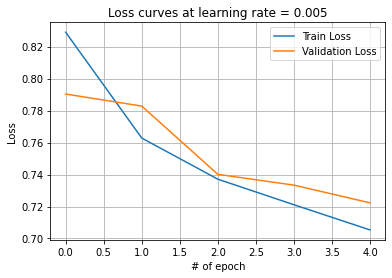

Final test from best model : avg_acc = 0.6796572804450989


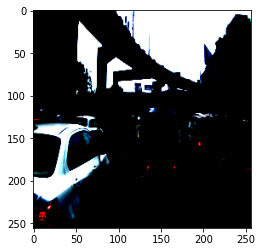

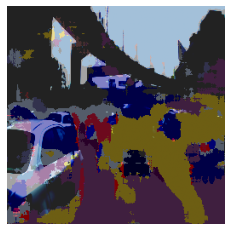

In [38]:
# Run this cell to train the model from scratch
# Make sure to set the number of epochs (epochs) and learning rate (learning_rate) to match what you want
epochs = 5
n_class = 27
criterion = dice_coefficient_loss()
resNet_model = resNet(n_class=n_class)
print("No. of classes = ",n_class)
learning_rate = 0.005
optimizer = optim.Adam(resNet_model.parameters(), lr=learning_rate)
resNet_model.apply(init_weights)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    resNet_model = resNet_model.cuda()

print("boutta train") 
train_loss, val_loss = train(0.005)
best_val_loss = float('inf')
curr_val_loss = np.min(np.asarray(val_loss))
if(curr_val_loss < best_val_loss):
    best_val_loss = curr_val_loss
    best_learning_rate = learning_rate
print("Best validation loss = {}".format(best_val_loss))
plot_loss_curves(train_loss,val_loss, learning_rate)
test(learning_rate, epochs)


Final test from best model : avg_acc = 0.7069427371025085


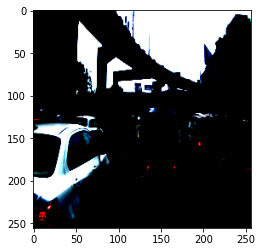

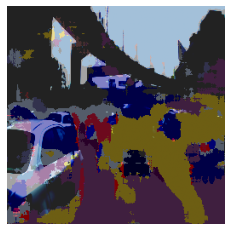

In [39]:
# Teting the model (learning_rate = 0.005, epoechs = 5)
learning_rate = 0.005
epochs = 5

test(learning_rate, epochs)